In [2]:
### Import libraries

# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

2.13.0


In [ ]:
!pip install numpy==1.23.5

In [3]:


#Array che contiene le categorie di ogni time series. Dim 48000x1
categories = np.load("/kaggle/input/training-dataset/categories.npy")
#Array che contiene i valori delle time series. Dim 48000x2776
training_data = np.load("/kaggle/input/training-dataset/training_data.npy")
#Array che contiene gli indici che descrivono gli estremi degli intervalli validi delle time series. Dim 48000x2
valid_periods = np.load("/kaggle/input/training-dataset/valid_periods.npy")

categories.shape, training_data.shape, valid_periods.shape


((48000,), (48000, 2776), (48000, 2))

In [4]:
def train_test_split(training_data, valid_periods, categories, train_ratio=0.8):
    columns = ["training", "test", "category"]
    data = pd.DataFrame(index=range(training_data.shape[0]), columns=columns)

    for i in range(training_data.shape[0]):

        start = valid_periods[i,0]
        end = valid_periods[i,1]
        non_zero_samples = end - start
        #Valori validi solo quando train_ratio = 0.8. In questo caso nel test si fitta almeno una window di lunghezza 210 quando il numero di samples è >= 1050
        if non_zero_samples >= 1050:
            train_len = round(non_zero_samples*train_ratio)
        else: #Altrimenti riserva almeno una window nel test set
            train_len = non_zero_samples - 210

        test_len = non_zero_samples-train_len

        training_samples=training_data[i, start : start + train_len]
        test_samples=training_data[i,start+train_len:]

        data.loc[i] = [training_samples, test_samples, categories[i]]
    return data

In [5]:
dataset = train_test_split(training_data, valid_periods, categories)

In [6]:
#We keep the rows where we can fit at least one window in the set! (remember that window = 200 and telescope = 9)
dataset = dataset[dataset['test'].apply(lambda x: len(x) >= 210)]
dataset = dataset[dataset['training'].apply(lambda x: len(x) >= 210)]

In [7]:
dataset = dataset.reset_index(drop=True)
dataset

,training,test,category
0,"[0.49166666666666664, 0.524074074074074, 0.544...","[0.3861111111111111, 0.3398148148148148, 0.275...",D
1,"[0.48, 0.5, 0.588, 0.42, 0.288, 0.3, 0.288, 0....","[0.644, 0.408, 0.212, 0.316, 0.532, 0.264, 0.5...",D
2,"[0.007403979639055993, 0.0, 0.0179546506247107...","[0.3476168440536789, 0.34372975474317446, 0.35...",D
3,"[0.04081632653061224, 0.05102040816326531, 0.0...","[0.46938775510204084, 0.45918367346938777, 0.4...",D
4,"[0.6078697421981004, 0.6065128900949797, 0.626...","[0.514246947082768, 0.5359565807327001, 0.5210...",D
...,...,...,...
2453,"[0.0, 0.0, 0.006736068585425597, 0.00122473974...","[0.5474586650336803, 0.5260257195345989, 0.497...",F
2454,"[0.0, 0.010303967027305513, 0.0216383307573415...","[0.5059247810407007, 0.4925296239052035, 0.460...",F
2455,"[0.011438474870017331, 0.0076256499133448875, ...","[0.43743500866551127, 0.42010398613518196, 0.4...",F
2456,"[0.002886002886002886, 0.0, 0.0028860028860028...","[0.43722943722943725, 0.4213564213564214, 0.39...",F


In [8]:
def build_sequences(df, window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy()
    padding_check = df.size%window

    #print(temp_df.size)

    if(padding_check != 0):
        # Compute padding length
        padding_len = window - df.size%window
        padding = np.zeros((padding_len), dtype='float32')
        temp_df = np.concatenate((padding,df))
        assert temp_df.size % window == 0

    #print(temp_df.size)
    for idx in np.arange(0,temp_df.size-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_df[idx+window:idx+window+telescope])

    if len(dataset) == 0:
        return dataset, labels
    else:
        return np.vstack(dataset), np.vstack(labels)
    return dataset, labels

In [10]:
#data is a pandas series containing 48000 lists (either training, validation or test)
def build_sequence_dataset(data):
    dataset = []
    labels = []
    for i in range(data.size):
        dset, labs = build_sequences(data[i], window=200, stride=1, telescope=9)
        if len(dset) == 0:
            continue
        dataset.append(dset)
        labels.append(labs)

    return dataset, labels

In [11]:
def THE_SEQUENCER(full_dataset):
    training_dataset, training_labels = build_sequence_dataset(dataset["training"])
    test_dataset, test_labels = build_sequence_dataset(dataset["test"])
    return training_dataset, training_labels, test_dataset, test_labels

In [12]:
training_dataset, training_labels, test_dataset, test_labels = THE_SEQUENCER(dataset)

In [13]:
for i in np.random.randint(0, len(training_dataset), size=5):
  print("TRAINING Index: {}, Number of sequences: {}, Window length: {}".format(i, training_dataset[i].shape[0], training_dataset[i].shape[1]))
  print("TEST Index: {}, Number of sequences: {}, Window length: {}".format(i, test_dataset[i].shape[0], test_dataset[i].shape[1]))

TRAINING Index: 860, Number of sequences: 391, Window length: 200
TEST Index: 860, Number of sequences: 191, Window length: 200
TRAINING Index: 1294, Number of sequences: 191, Window length: 200
TEST Index: 1294, Number of sequences: 191, Window length: 200
TRAINING Index: 1130, Number of sequences: 191, Window length: 200
TEST Index: 1130, Number of sequences: 191, Window length: 200
TRAINING Index: 1095, Number of sequences: 191, Window length: 200
TEST Index: 1095, Number of sequences: 191, Window length: 200
TRAINING Index: 1638, Number of sequences: 191, Window length: 200
TEST Index: 1638, Number of sequences: 191, Window length: 200


Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          33792     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 200, 128)          49280     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)              0         
                                                                 
Total params: 83457 (326.00 KB)
Trainable params: 83457 (326.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

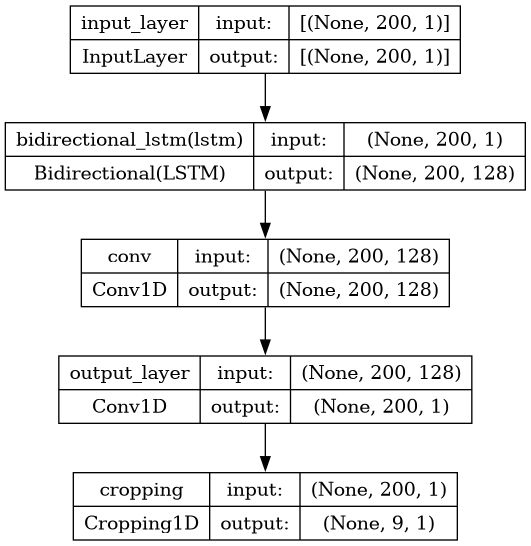

In [14]:
### Build the model


batch_size = 64
epochs = 200

input_shape = (200,1)
output_shape = (9,1)
input_shape, output_shape

def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
from tqdm import tqdm
# Train the model

for i in tqdm(range(len(training_dataset))):

  history = model.fit(
      x = training_dataset[i],
      y = training_labels[i],
      batch_size = batch_size, 
      epochs = 200,
      verbose = 0,
      validation_split=.1,
      callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
          tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
      ]
  ).history

  1%|          | 26/2458 [02:01<3:16:12,  4.84s/it]

In [ ]:
model.save('Second model')

In [ ]:
!zip -r file.zip /kaggle/working